In [187]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [188]:
%matplotlib inline

In [189]:
import xgboost
from xgboost import XGBRegressor

In [190]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [191]:
from multicam.mah import get_mah

# Load data

In [192]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [193]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']
# ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


## Load merger data

In [194]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [195]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [196]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning, these will return np.nan's which is expected. 
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

In [197]:
x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

# use scale_bins instead of scales, take max over mergers in each bin.
x3 = np.zeros((x2.shape[0], scale_bins.shape[0]))
for ii, scale in enumerate(scales):
    jj = np.where(scale >= scale_bins)[0][-1]
    arr = np.vstack([x3[:, jj], x2[:, ii]])
    assert arr.shape == (2, 10000)
    x3[:, jj] = np.max(arr, axis=0)

# Train xgboost to predict concentration

In [198]:
# subsample ma to reduce features every 10 
x = ma[:,::10]
y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

In [199]:
# test train split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((5000, 17), (5000, 5), (2500, 17), (2500, 5), (2500, 17), (2500, 5))

In [201]:
from multicam.models import XGB
model = XGB(17, 5, 
            {'max_depth': 7, 'n_estimators': 1000, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'early_stopping_rounds': 100,}, 
            { 'verbose': True, 'eval_set': [(x_val, y_val)]}, use_multicam=False, use_multicam_no_ranks=False)

In [202]:
model.fit(x_train, y_train)

[0]	validation_0-rmse:3.75979


[1]	validation_0-rmse:3.40898
[2]	validation_0-rmse:3.10390
[3]	validation_0-rmse:2.82745
[4]	validation_0-rmse:2.57982
[5]	validation_0-rmse:2.35975
[6]	validation_0-rmse:2.16373
[7]	validation_0-rmse:1.98595
[8]	validation_0-rmse:1.83195
[9]	validation_0-rmse:1.69497
[10]	validation_0-rmse:1.57447
[11]	validation_0-rmse:1.46999
[12]	validation_0-rmse:1.38001
[13]	validation_0-rmse:1.29960
[14]	validation_0-rmse:1.22944
[15]	validation_0-rmse:1.16982
[16]	validation_0-rmse:1.11682
[17]	validation_0-rmse:1.07442
[18]	validation_0-rmse:1.03727
[19]	validation_0-rmse:1.00396
[20]	validation_0-rmse:0.97680
[21]	validation_0-rmse:0.95357
[22]	validation_0-rmse:0.93183
[23]	validation_0-rmse:0.91486
[24]	validation_0-rmse:0.89955
[25]	validation_0-rmse:0.88690
[26]	validation_0-rmse:0.87620
[27]	validation_0-rmse:0.86661
[28]	validation_0-rmse:0.85708
[29]	validation_0-rmse:0.85106
[30]	validation_0-rmse:0.84740
[31]	validation_0-rmse:0.84216
[32]	validation_0-rmse:0.83751
[33]	validation_0

In [203]:
y_pred = model.predict(x_test)

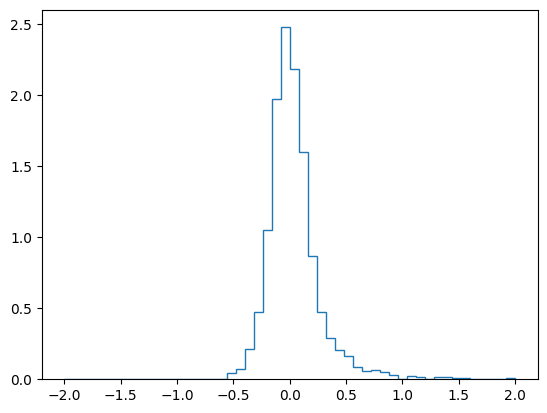

In [205]:
# evaluate by looking at histograms of residuals
res = (y_pred[:, 0] - y_test[:, 0])/y_test[:, 0]
plt.hist(res, bins=50, range=(-2, 2), histtype='step', density=True, label='residuals');

In [209]:
from multicam.correlations import spearmanr
params = ['cvir', 'xoff', 't/|u|', 'spin_bullock', 'c_to_a']
for ii in range(5):
    print(params[ii])
    print(spearmanr(y_test[:, ii], y_pred[:, ii]))

cvir
0.8351853550056569
xoff
0.7115104047437648
t/|u|
0.8250025801811423
spin_bullock
0.5463697818315696
c_to_a
0.49641840921449926


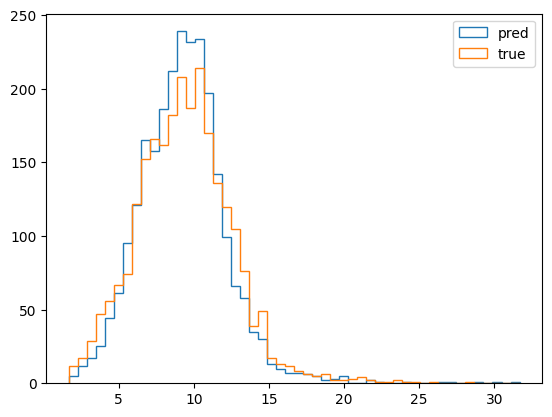

In [208]:
# concentration
_, bins, _ = plt.hist(y_pred[:,0], histtype='step', bins=50, label='pred')
plt.hist(y_test[:, 0], bins=bins, histtype='step', label='true')
plt.legend()

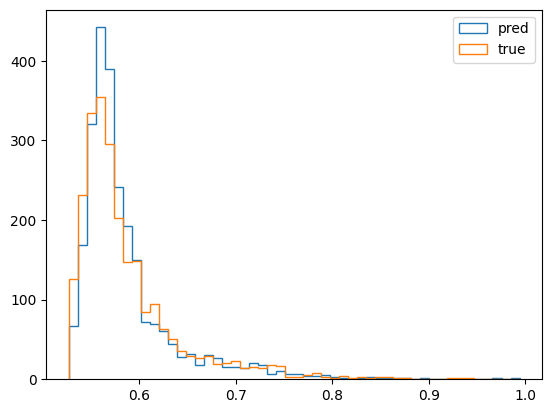

In [211]:
# concentration
_, bins, _ = plt.hist(y_pred[:,2], histtype='step', bins=50, label='pred')
plt.hist(y_test[:, 2], bins=bins, histtype='step', label='true')
plt.legend()

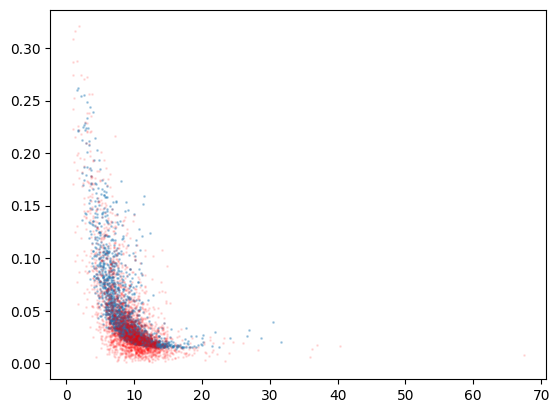

In [215]:
# scatter 
plt.scatter(y_pred[:, 0], y_pred[:, 1], s=1, alpha=0.3)
plt.scatter(y_test[:, 0], y_test[:, 1], s=1, alpha=0.1, c='r')

# Predicting concentration with coarse merger information

In [169]:
# subsample ma to reduce features every 10 
x1 = ma[:, ::10]
x = np.concatenate([x1, x3], axis=1)
y = cvir[:, None]

In [170]:
# same initiliazation 
model_m = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [171]:
# test train split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((5000, 37), (5000, 1), (2500, 37), (2500, 1), (2500, 37), (2500, 1))

In [180]:
from multicam.models import XGB
model_m = XGB(37, 1, 
            {'max_depth': 7, 'n_estimators': 1000, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'eval_metric': 'mae', 'early_stopping_rounds': 100,}, 
            { 'verbose': True, 'eval_set': [(x_val, y_val)]}, use_multicam=False, use_multicam_no_ranks=False)

In [181]:
model_m.fit(x_train, y_train)

[0]	validation_0-mae:7.77669
[1]	validation_0-mae:7.00957
[2]	validation_0-mae:6.32711


[3]	validation_0-mae:5.71541
[4]	validation_0-mae:5.15923
[5]	validation_0-mae:4.66148
[6]	validation_0-mae:4.22221
[7]	validation_0-mae:3.83007
[8]	validation_0-mae:3.47972
[9]	validation_0-mae:3.16160
[10]	validation_0-mae:2.88451
[11]	validation_0-mae:2.64758
[12]	validation_0-mae:2.43839
[13]	validation_0-mae:2.25773
[14]	validation_0-mae:2.10078
[15]	validation_0-mae:1.96676
[16]	validation_0-mae:1.85186
[17]	validation_0-mae:1.75539
[18]	validation_0-mae:1.67254
[19]	validation_0-mae:1.60468
[20]	validation_0-mae:1.54663
[21]	validation_0-mae:1.49929
[22]	validation_0-mae:1.45901
[23]	validation_0-mae:1.42544
[24]	validation_0-mae:1.39892
[25]	validation_0-mae:1.37635
[26]	validation_0-mae:1.35636
[27]	validation_0-mae:1.34126
[28]	validation_0-mae:1.32950
[29]	validation_0-mae:1.31869
[30]	validation_0-mae:1.30938
[31]	validation_0-mae:1.30179
[32]	validation_0-mae:1.29481
[33]	validation_0-mae:1.28946
[34]	validation_0-mae:1.28662
[35]	validation_0-mae:1.28127
[36]	validation_0

In [182]:
model_m.reg.best_iteration, model_m.reg.best_score

(117, 1.2398039604187012)

In [183]:
y_pred = model_m.predict(x_test)

In [184]:
from multicam.correlations import spearmanr
spearmanr(y_test[:, 0], y_pred)

0.8505610008577602

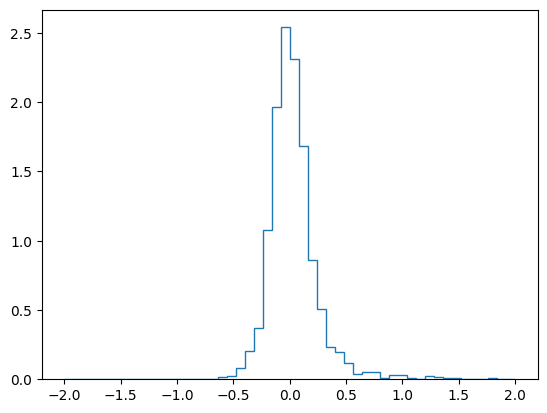

In [185]:
# evaluate by looking at histograms of residuals
res = (y_pred[:,0] - y_test[:, 0])/y_test[:, 0]
plt.hist(res, bins=50, range=(-2, 2), histtype='step', density=True, label='residuals');

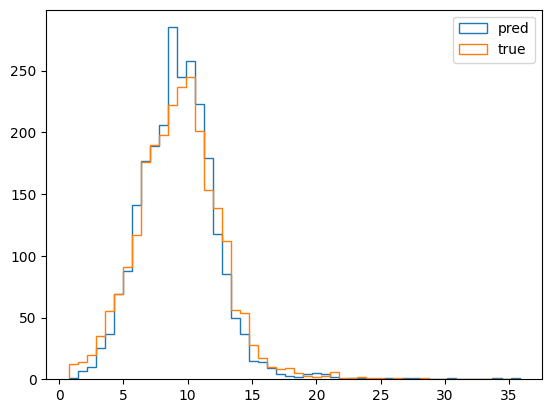

In [186]:
_, bins, _ = plt.hist(y_pred, histtype='step', bins=50, label='pred')
plt.hist(y_test[:, 0], bins=bins, histtype='step', label='true')
plt.legend()